## 線形回帰

### 正規方程式

In [1]:
import numpy as np

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

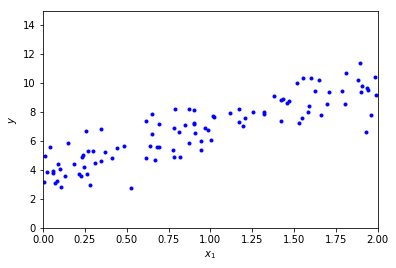

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.plot(X, y, 'b.')
plt.xlabel('$x_1$')
plt.ylabel('$y$')
plt.axis([0, 2, 0, 15])
plt.show()

In [3]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [4]:
theta_best

array([[ 3.90341667],
       [ 3.05898316]])

In [5]:
# x1が0と2の時を予測してみる
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[  3.90341667],
       [ 10.02138299]])

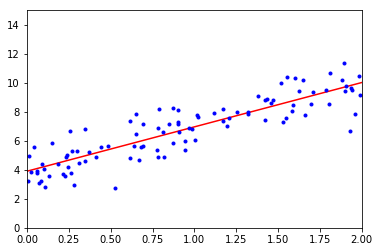

In [6]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
# scikit-learnを使った場合
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

/Users/uno/.pyenv/versions/3.6.1/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


(array([ 3.90341667]), array([[ 3.05898316]]))

In [8]:
lin_reg.predict(X_new)

array([[  3.90341667],
       [ 10.02138299]])

### 勾配降下法
- 線形回帰におけるMSEコスト関数は凸関数である
- 勾配降下方を使用するときはすべての特徴量のスケールが合うように指定すべき

#### 勾配降下法の種類は3つ
- バッチ勾配降下法　（全訓練データを用いるもの）
- 確率的勾配降下法　（訓練データからランダムで１つ選んでいく）
- ミニバッチ勾配降下法　（ランダムで選んだ小さい集合を用いる）

In [9]:
eta = 0.01 #学習率
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)
theta_bgd = []

In [10]:
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta*gradients
    if iteration%10 == 0:
#         print('theta:', theta[0], theta[1])
        theta_bgd.append([theta[0], theta[1]])

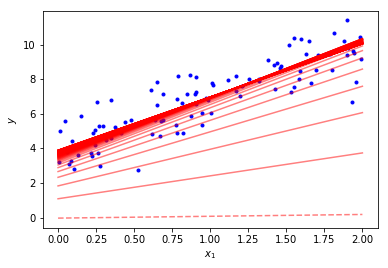

In [11]:
plt.plot(X, y, 'b.')
for i in range(len(theta_bgd)):
    X_new = np.array([[0],[2]])
    X_new_b = np.c_[np.ones((2, 1)), X_new]
    y_predict = X_new_b.dot(theta_bgd[i])
    if i == 0:
        plt.plot(X_new, y_predict, 'r--', alpha=0.5)
    else:
        plt.plot(X_new, y_predict, 'r-', alpha=0.5)
plt.xlabel('$x_1$')
plt.ylabel('$y$')
plt.show()

### 確率的勾配降下法
- 上のバッチ勾配降下法では、勾配の計算で「すべての訓練セット」を使うため、計算速度が遅いことが問題
- 確率的勾配降下方法では、訓練セットからランダムで１つ選び勾配を計算することで高速化する
- 学習率は徐々に小さくしていく手法が一般的(焼きなまし方法)

In [12]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0/(t+t1) #学習が進みのつれ、徐々に学習率を小さくしていく

In [13]:
theta = np.random.randn(2, 1)
theta_sgd = [theta]
eta = 0.0001
for epoch in range(n_epochs):
    for i in range(m):  
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        if i == 0:
            theta_sgd.append([theta[0], theta[1]])

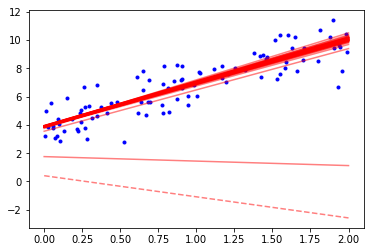

In [14]:
plt.plot(X, y, 'b.')
for i in range(len(theta_sgd)):
    X_new = np.array([[0],[2]])
    X_new_b = np.c_[np.ones((2, 1)), X_new]
    y_predict = X_new_b.dot(theta_sgd[i])
    if i == 0:
        plt.plot(X_new, y_predict, 'r--', alpha=0.5)
    else:
        plt.plot(X_new, y_predict, 'r-', alpha=0.5)        
plt.show()

### ミニバッチ勾配降下法
- 訓練データからランダムで小さい集合を抽出して、それをつかう
- GPUアーキテクチャとの親和性が高く、パフォーマンスの向上が期待できる
- ミニバッチが大規模な場合にはSGDよりも最小値に近づきやすい
- 一方で、局所的な最小値に一度落ちると、抜けづらくなってします

In [15]:
minibatch_size = 20
theta = np.random.randn(2, 1)
theta_mgd = [theta]
eta = 0.0001

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        if i == 0:
            theta_mgd.append([theta[0], theta[1]])

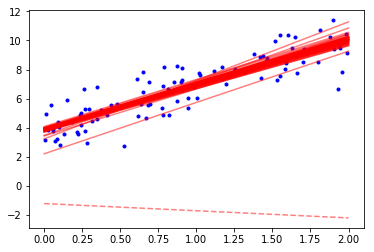

In [16]:
plt.plot(X, y, 'b.')
for i in range(len(theta_mgd)):
    X_new = np.array([[0],[2]])
    X_new_b = np.c_[np.ones((2, 1)), X_new]
    y_predict = X_new_b.dot(theta_mgd[i])
    if i == 0:
        plt.plot(X_new, y_predict, 'r--', alpha=0.5)
    else:
        plt.plot(X_new, y_predict, 'r-', alpha=0.5)        
plt.show()

#### バッチGD, SGD, ミニバッチGDの収束の様子

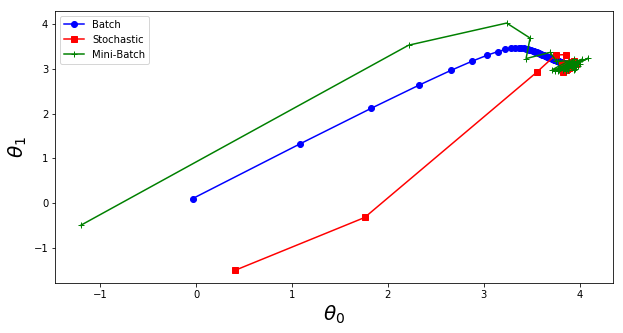

In [17]:
plt.figure(figsize=(10,5))
plt.plot(np.array(theta_bgd)[:, 0], np.array(theta_bgd)[:, 1], 'b-o', label='Batch')
plt.plot(np.array(theta_sgd)[:, 0], np.array(theta_sgd)[:, 1], 'r-s', label='Stochastic')
plt.plot(np.array(theta_mgd)[:, 0], np.array(theta_mgd)[:, 1], 'g-+', label='Mini-Batch')
plt.legend()
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$", fontsize=20)
plt.show()

### 多項式回帰

In [18]:
import numpy as np
import numpy.random as rnd
np.random.seed(42)

In [21]:
m = 100
X = 6*np.random.rand(m, 1)-3
y = 0.5*X**2 + X + 2 + np.random.randn(m, 1)

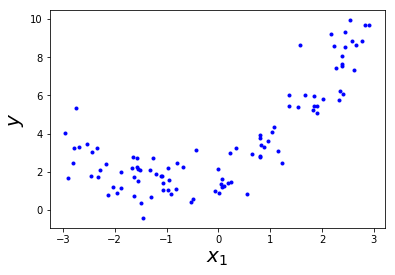

In [31]:
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.show()

In [34]:
# sklearnによる重回帰
# XをX**2に変換して新たな特徴量を作る
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False) # degreeは次数（ここでは２次多項式）
X_poly = poly_features.fit_transform(X)

In [35]:
# 新たな特徴量X_polyで学習する
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 1.91673157]), array([[ 1.11651528,  0.56296804]]))

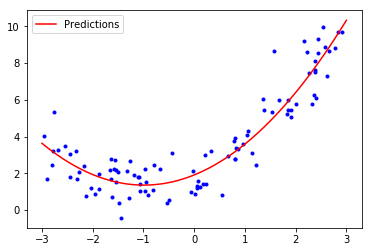

In [42]:
X_new=np.linspace(-3,3,100).reshape(100,1)
X_new_poly=poly_features.transform(X_new)
y_new=lin_reg.predict(X_new_poly)
plt.plot(X,y,'b.')
plt.plot(X_new,y_new,'r-', label='Predictions')
plt.legend()
plt.show()

### 学習曲線
- 上記では２次多項式だったが、関数によっては何次がよいのかわからない
- 次数を探索するため、過学習を観察する学習曲線が必要である

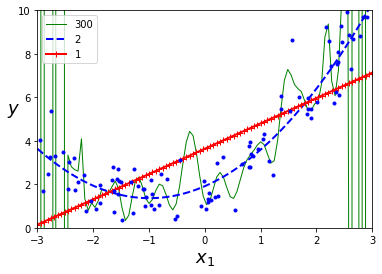

In [45]:
# さきほどのモデルを2次よりも大きい多項式でやってみる（1次、2次、300次）
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

# 緑の300次元はとても過学習していることがわかる

In [51]:
from  sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

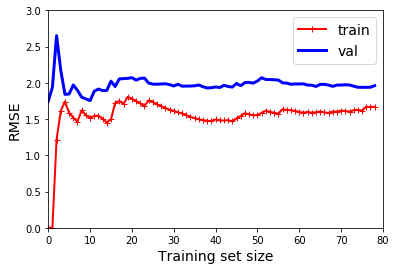

In [53]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

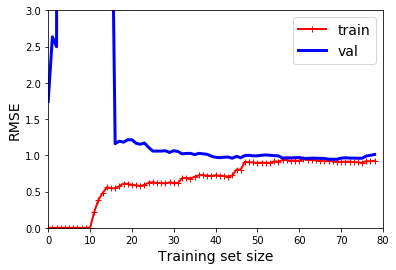

In [55]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()